<a href="https://colab.research.google.com/github/GWFJ/comp90051-a1-team-8/blob/main/Preprocessing/Resampling/domain2_resampling(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets sentence-transformers seqeval Keras-Preprocessing plotly imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import json
import csv
import torch
import torch.nn as nn
import ast
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset,Dataset,DatasetDict,ClassLabel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import SVC
from tqdm import tqdm, trange
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel, BertConfig
import plotly.express as px
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def load_data(path):
  with open(path) as file:
    data = [json.loads(row) for row in file]
  file.close()
  return data

In [5]:
def l_df(data):
  return pd.DataFrame(data)

In [6]:
#Train Data
domain1_train = load_data('/content/drive/MyDrive/A1 Data /domain1_train.json')
domain2_train = load_data('/content/drive/MyDrive/A1 Data /domain2_train.json')

#Test Data
test_set = load_data('/content/drive/MyDrive/A1 Data /test_set.json')

In [7]:
#Dataframes
domain1_df = l_df(domain1_train)
domain2_df = l_df(domain2_train)
test_df = l_df(test_set)

In [8]:
def padd_tokens(text):

  max_length = max(len(seq) for seq in text)
  padded_text = pad_sequences(text, maxlen=max_length, padding='post', truncating='post')

  return padded_text

In [9]:
def plot_resample(dataframe, title):

    color_discrete_map = {
      '0': 'cyan',
      '1': 'pink'
    }

    fig_domain2 = px.histogram(dataframe, x='label', color='label',
                            title=title,
                            color_discrete_map=color_discrete_map)
    fig_domain2.update_xaxes(title_text='Labels')
    fig_domain2.update_yaxes(title_text='Counts')

    fig_domain2.show()

In [20]:
###Resampling on domain2 scatter plot:


def plot_resampling_scatter(X, y, title):

    plt.subplots( figsize=(15, 25))
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor="k")
    plt.title(title)
    plt.show()

In [10]:
##Resampling function:


###Resampling algorithms:

samplers = [SMOTE(random_state=0), SMOTEENN(random_state=0), SMOTETomek(random_state=0)]

def resample(X,y,sampler):

   X_resampled, y_resampled = sampler.fit_resample(X, y)

   return X_resampled, y_resampled




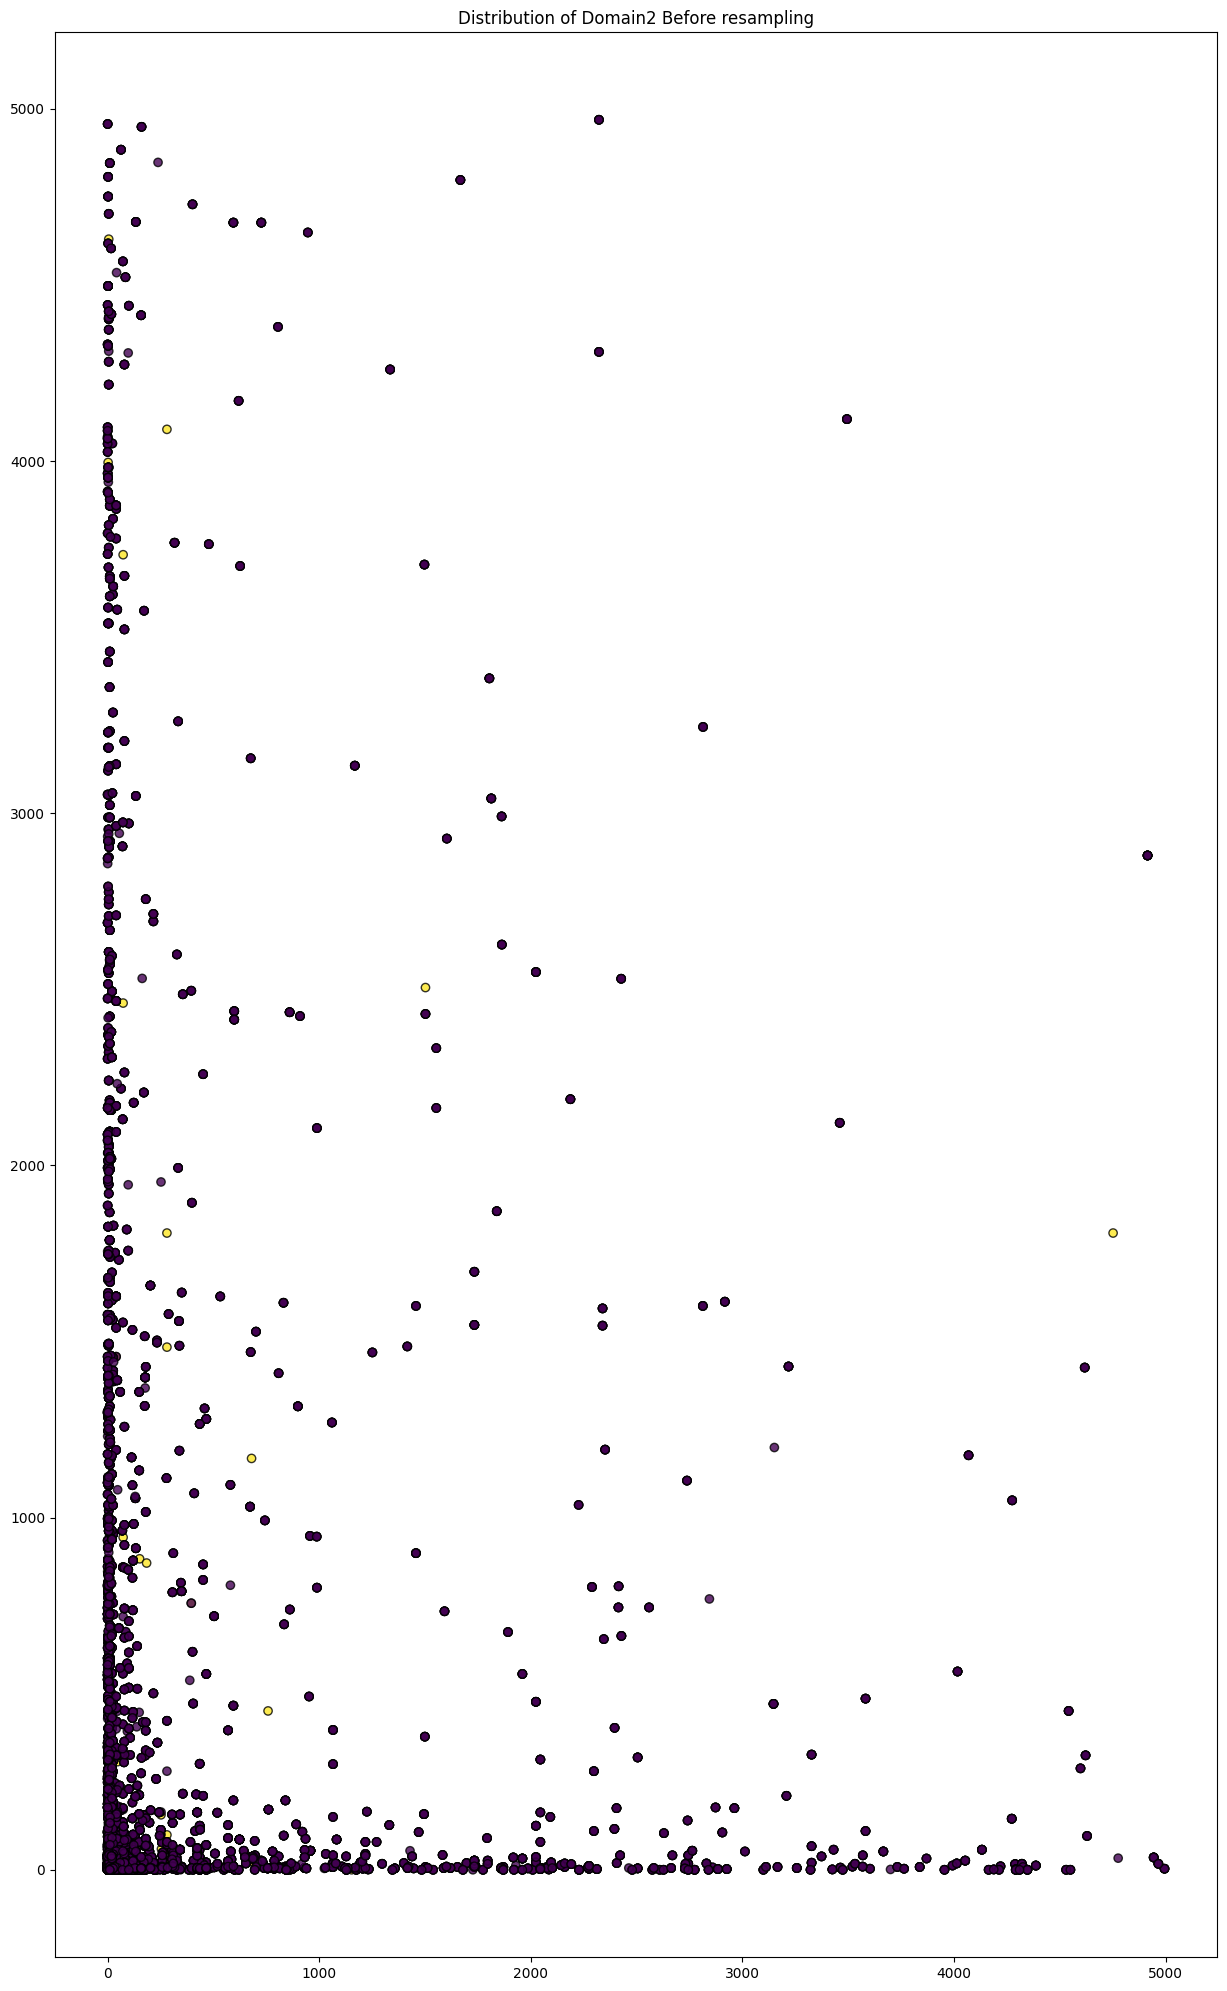

In [21]:


##domain2:

X = padd_tokens(domain2_df['text'])
y = domain2_df['label']

df = pd.DataFrame(data = X)
df['label'] = y


##plot
plot_resample(df, "Distribution of Domain2 Before resampling")

plot_resampling_scatter(X,y, "Distribution of Domain2 Before resampling")

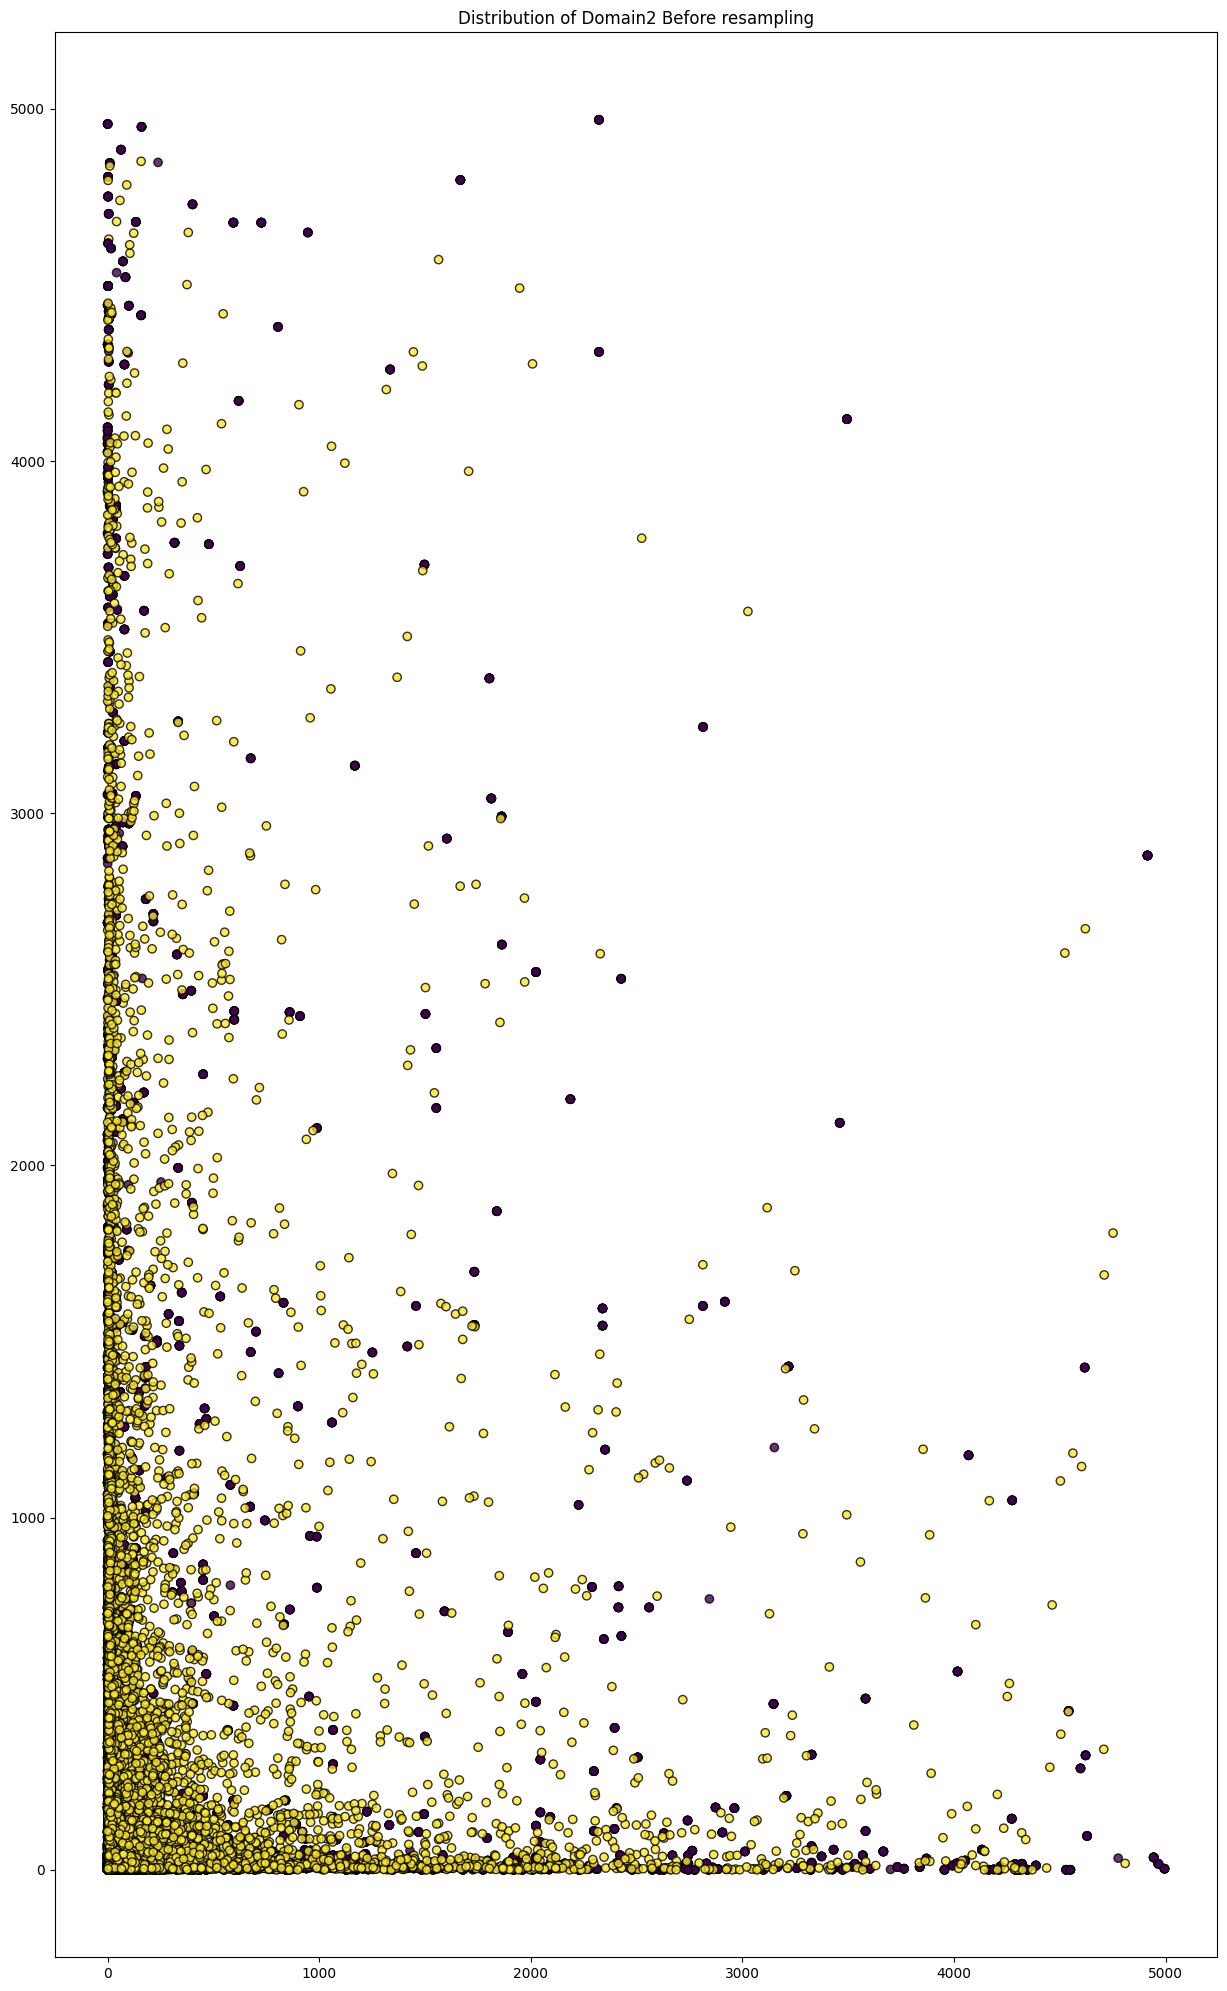

In [25]:
###SMOTE resampling

x_res0, y_res0 = resample(X,y, samplers[0])

df = pd.DataFrame(data = x_res0)
df['label'] =  y_res0

plot_resample(df, "Distribution of Domain2 after resampling using SMOTE")

plot_resampling_scatter(x_res0, y_res0, "Distribution of Domain2 Before resampling")


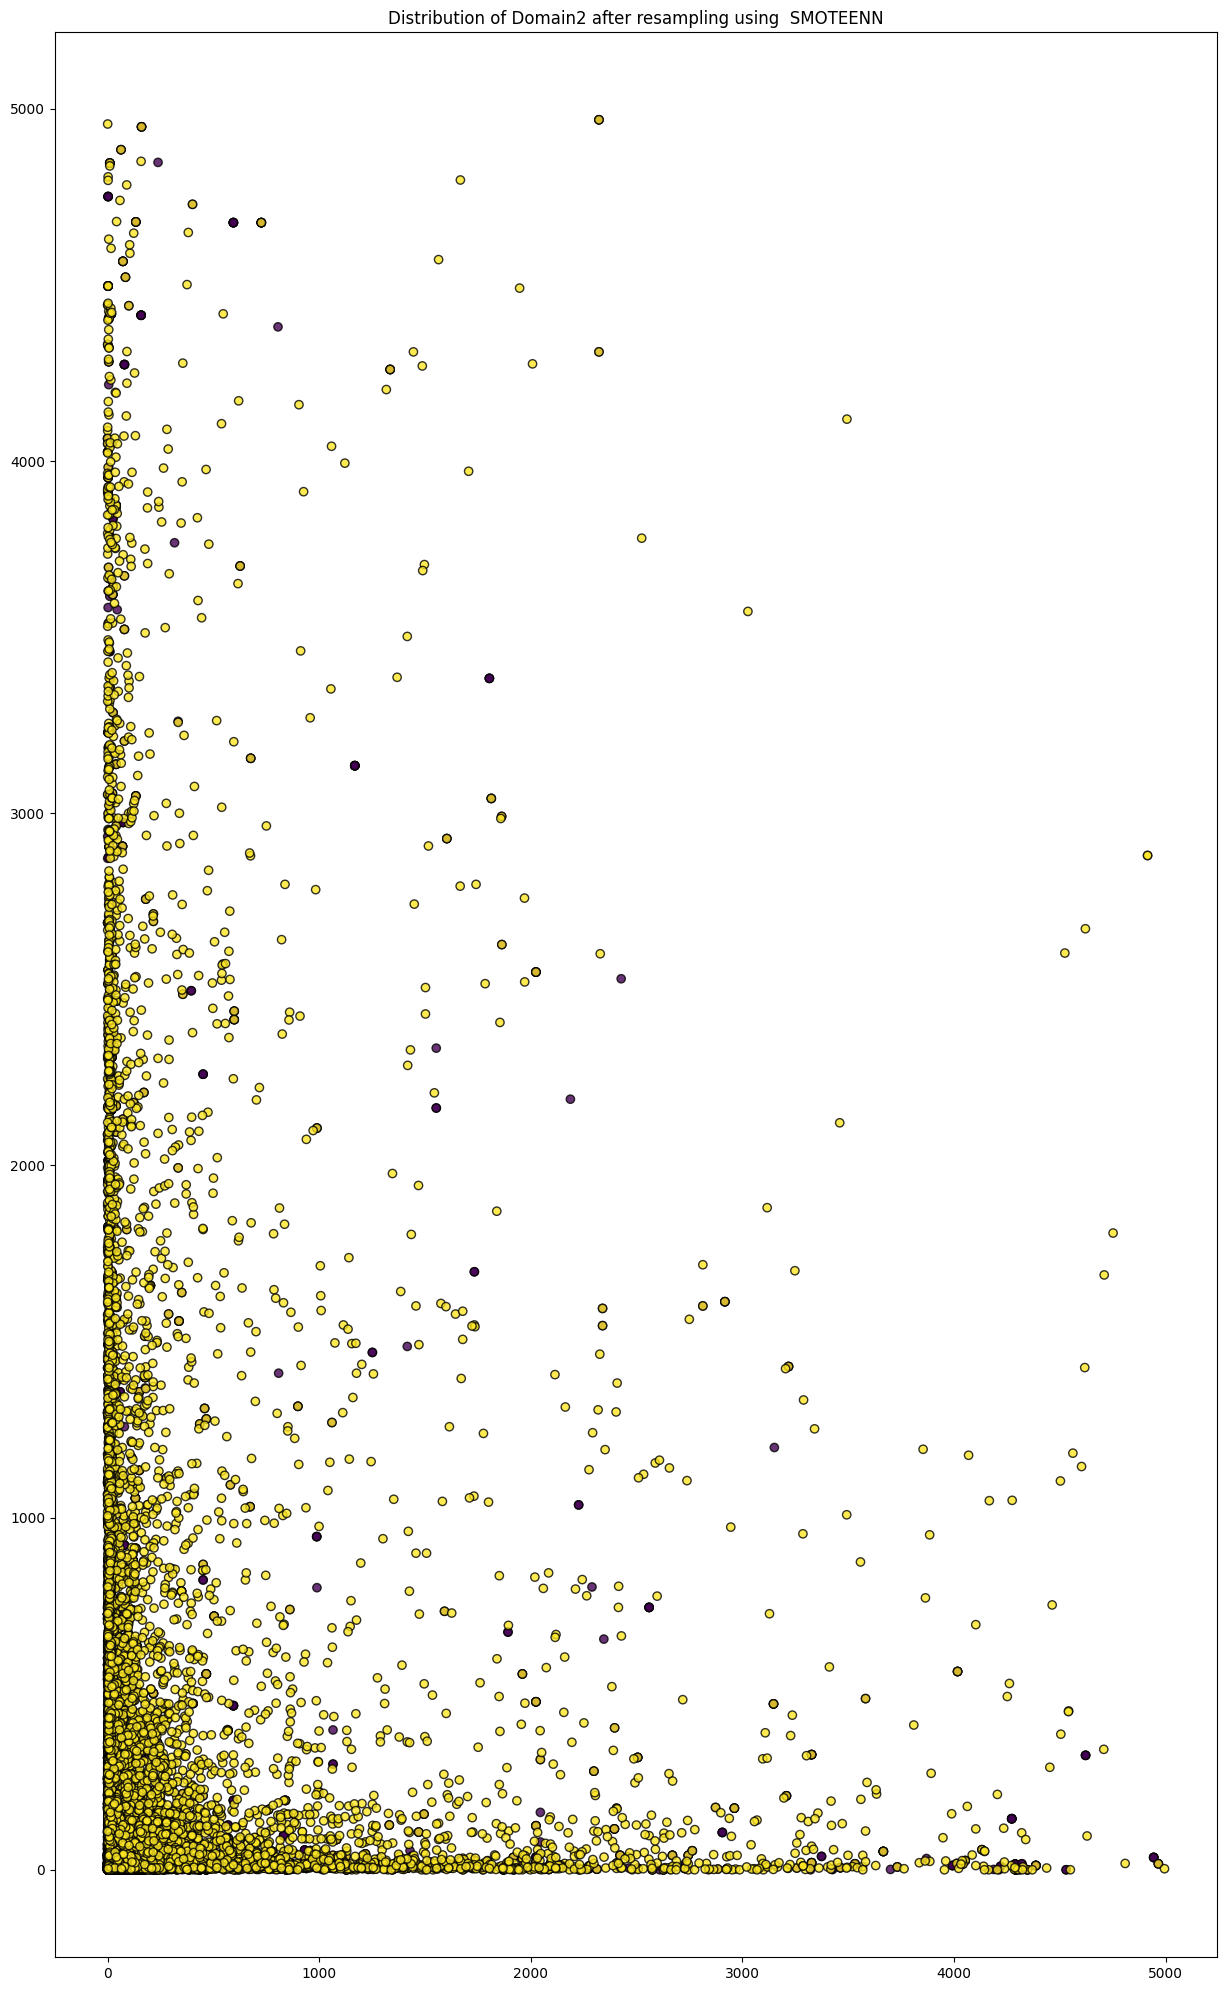

In [26]:
####SMOTEENN Resampling
x_res1, y_res1 = resample(X,y, samplers[1])

df = pd.DataFrame(data = x_res1)
df['label'] =  y_res1

plot_resample(df, "Distribution of Domain2 after resampling using  SMOTEENN")
plot_resampling_scatter(x_res1, y_res1, "Distribution of Domain2 after resampling using  SMOTEENN")

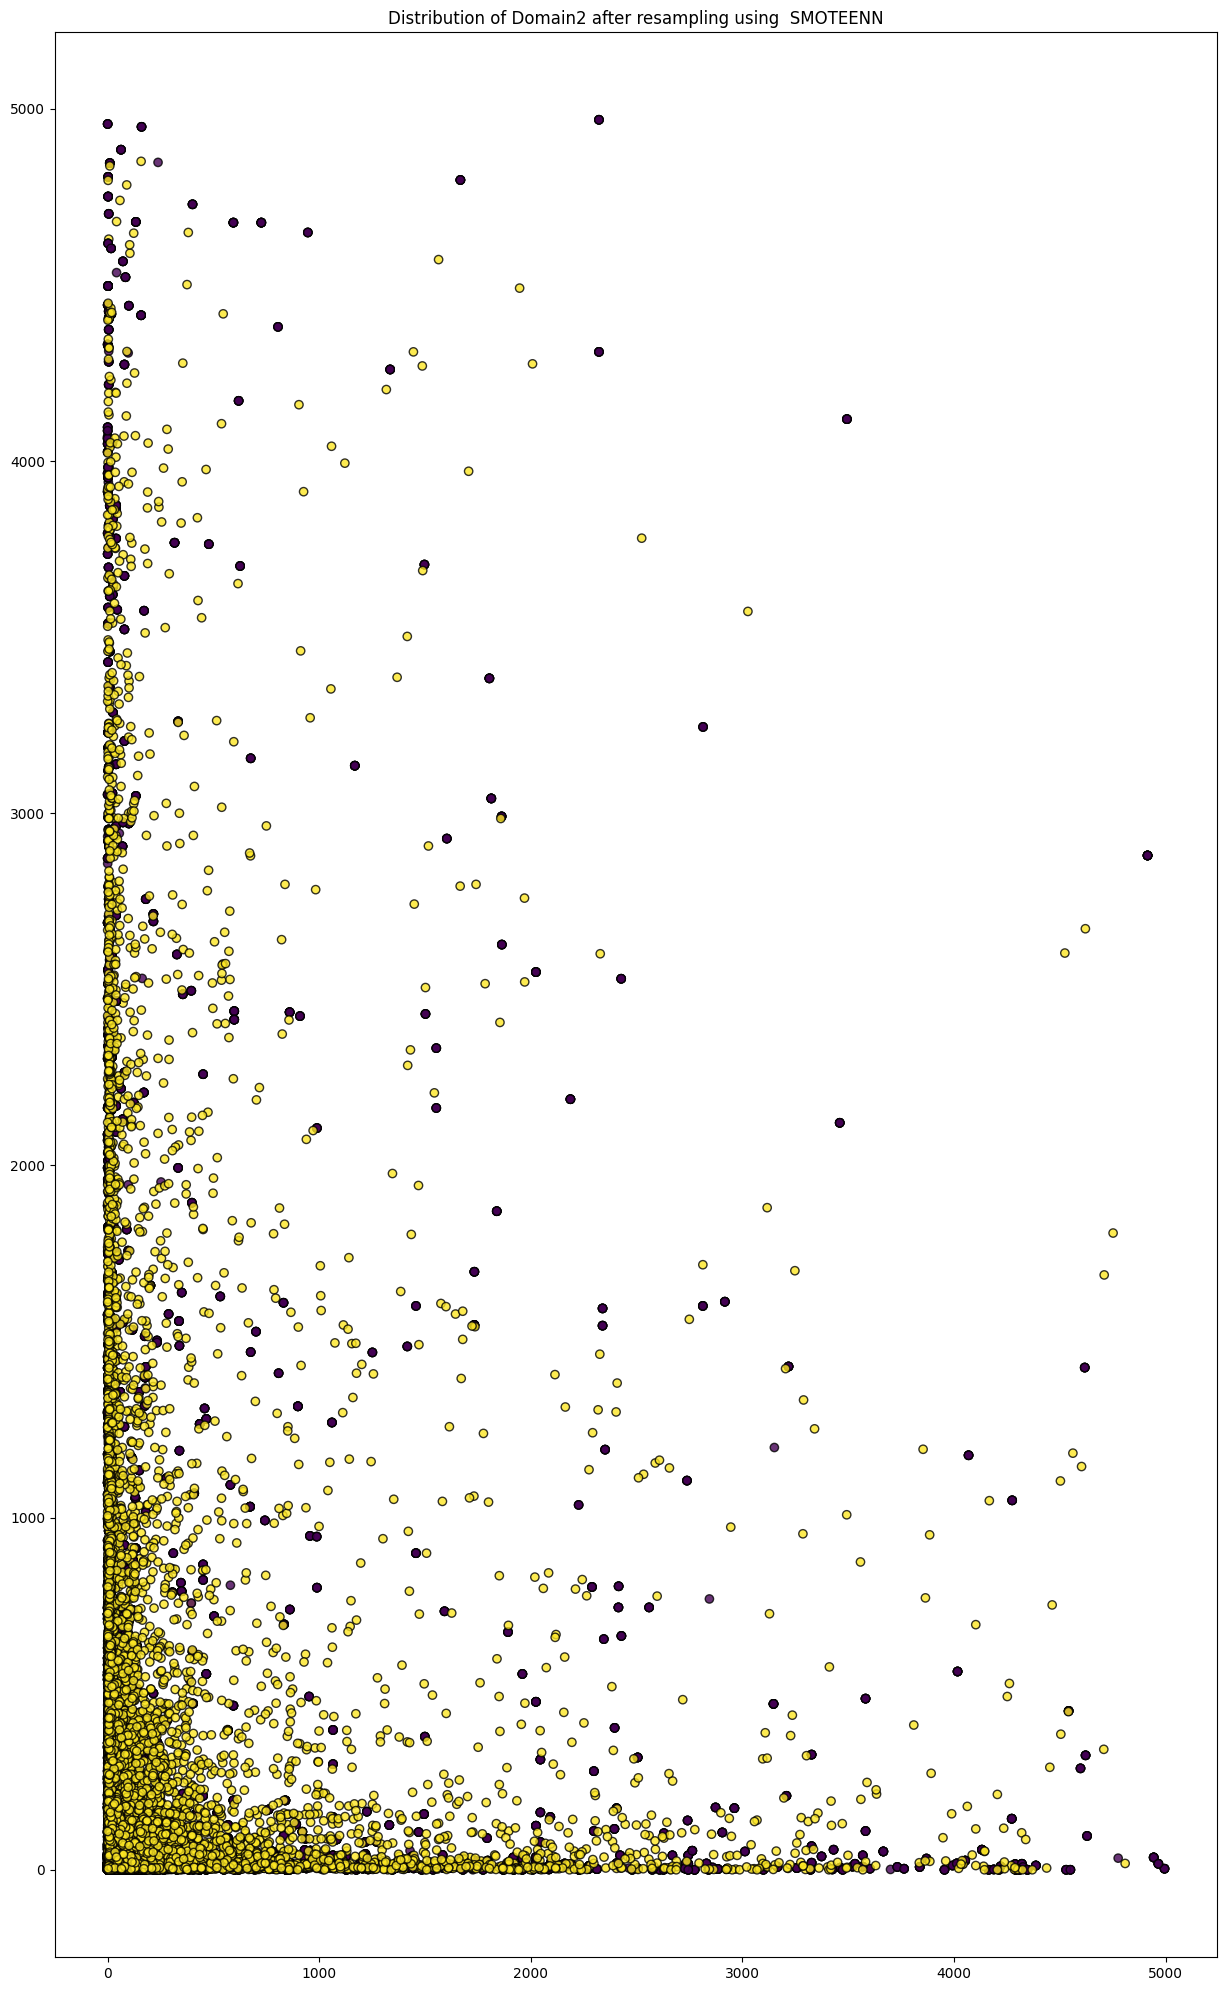

In [27]:
###Resampling using SMOTETomek

x_res2, y_res2 = resample(X,y, samplers[2])

df = pd.DataFrame(data = x_res2)
df['label'] =  y_res2

plot_resample(df, "Distribution of Domain2 after resampling using  SMOTETomek")
plot_resampling_scatter(x_res2, y_res2, "Distribution of Domain2 after resampling using  SMOTEENN")